In [ ]:
##############################################################################
## Fundamentals for pratical Text Analytics - document/word embeddings
##                                            more spacy, 
##                                            gensim to build our own ----> spacy
##                                            why:  dense numeric representations to capture meaning
##                                                  use downstream -> similarity, clustering, ML
##
##
## Learning goals:
##                 - continue spacy
##                 - foundational understanding of word vectors via Word2Vec
##                 - can roll our own vectors
##                 - generalized, pre-trained word vectors for S|UML tasks (intent classification)
##
##
## Great resources
##                 - https://spacy.io/usage/spacy-101
##                 - https://spacy.io/universe/category/courses
##
##
##############################################################################

In [ ]:
# installs
! pip install -U spacy 
# ! pip install -U textacy
! pip install newspaper3k
# ! pip install afinn
# ! pip install whatlies

     |████████████████████████████████| 6.0 MB 4.3 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 628 kB 55.7 MB/s 
     |████████████████████████████████| 181 kB 67.4 MB/s 
     |████████████████████████████████| 451 kB 48.9 MB/s 
     |████████████████████████████████| 10.1 MB 47.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 211 kB

In [ ]:
# imports
import spacy
from spacy import cli
from spacy import displacy

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
import seaborn as sns


# upcoming!
# from textacy.extract.keyterms import textrank
import gensim

# import textacy

from newspaper import Article
import json

# from afinn import Afinn


In [ ]:
# use spacy cli
MODEL = "en_core_web_md"

# https://spacy.io/models/en
cli.download(MODEL)

# nlp = language model
nlp = spacy.load(MODEL)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
############################################ WARMUP
##
##
## Scrape the Wikipedia Entry for the Netflix series Squid Game
## https://en.wikipedia.org/wiki/Squid_Game
##
## use the pre-loaded spacy NER model to parse the entities
## parse the entities into a dataframe
## create a barplot summarizing count by entity type
## TRICKY:  make it a horizontal barplot with the most frequent entity at the top of the chart
## 

In [ ]:
article = Article("https://en.wikipedia.org/wiki/Squid_Game")
article.download()
article.parse()
sg = article.text

In [ ]:
# remove new line characters = \n
sg = sg.replace("\n", "")

In [ ]:
len(sg)

61122

In [ ]:
doc = nlp(sg)

In [ ]:
# extract the entities
ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

In [ ]:
ents[:3]

[('2021', 0, 4, 'CARDINAL'),
 ('South Korean', 5, 17, 'NORP'),
 ('Netflix', 76, 83, 'ORG')]

In [ ]:
len(ents)

898

In [ ]:
df = pd.DataFrame(ents, columns=['text', 'start', 'end', 'entity'])

In [ ]:
df.head(3)

text  start  end    entity
0          2021      0    4  CARDINAL
1  South Korean      5   17      NORP
2       Netflix     76   83       ORG

In [ ]:
counts = df.entity.value_counts()
counts

PERSON         225
ORG            163
CARDINAL       135
DATE           117
NORP            70
GPE             57
WORK_OF_ART     46
ORDINAL         33
TIME            10
MONEY            9
PRODUCT          6
LOC              6
PERCENT          5
FAC              4
LANGUAGE         4
QUANTITY         3
EVENT            3
LAW              2
Name: entity, dtype: int64

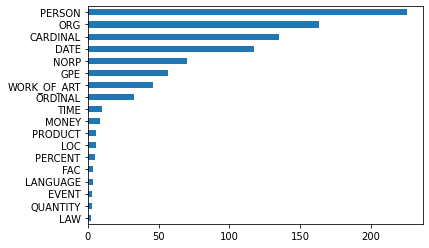

In [ ]:
# basic pandas plotting
counts.sort_values().plot(kind="barh")

In [ ]:
############################################ Word/Doc Vectors
##
##

In [ ]:
# lets review a simple document
tweet = "That movie by email@email.com was 🔥.  Please contact www.bu.edu"

doc = nlp(tweet)

In [ ]:
# spacy is a pipeline
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
# remember, we can slice up docs into tokens/spans
token = doc[0]
token

That

In [ ]:
# tokens have all sorts of attributes that were learned
token = doc[5]
token.is_oov

True

In [ ]:
# worth noting, a document can be comprised of sentences
# remember that we used to download punkt from nltk?
# that was a sentence tokenizer (divide into sentences)
# spacy has this built in
[sent for sent in doc.sents]

[That movie by email@email.com was 🔥.,  Please contact www.bu.edu]

In [ ]:
####################################### quick departure
# above we checked against spacy's learned vocabulary
# this is a check to see if a token is out-of-vocabulary (OOV)

# model reviews:
# https://spacy.io/usage/modelsa


In [ ]:
# this is just for reference
# 

v = nlp.vocab.vectors
v.shape

(20000, 300)

In [ ]:
# spacy stores text and tokens effeciently 
# https://spacy.io/usage/spacy-101#vocab

# spacy provides a way to lookup the vectors
nlp.vocab.strings["golf"]

# and we can reverse
nlp.vocab.strings[18149141486079540445]

## spacy is very flexible, and while vectors can be added and edited, 
## we can just include our own, which we will do later

'golf'

In [ ]:
#######################################  Vectors/Embeddings
##
## You have heard me use this term quite a bit
## we have seen this via PCA ----> take a large feature space and re-represent this in a new space
##     the goal was to encode information and reduce noise, right?
##
## we saw this in Tsne (2 embeddings) and UMAP (can be 2 or more depending on our needs)
## 
## 
## Well in text, we have the same idea
## we could always use the tools above, but there this is a "hot" field right now -> embeddings




![](https://miro.medium.com/max/2224/0*K5a1Ws_nsbEjhbYk.png)

> Above we can see words can be represented in these highly dimensional spaces.  The aim is to encapsulate context.  Remember bag-of-words removes sequence/order!


![](https://jalammar.github.io/images/word2vec/king-analogy-viz.png)

![](https://miro.medium.com/max/1400/1*cuOmGT7NevP9oJFJfVpRKA.png)


In [ ]:
# get some vectors

king = nlp("king").vector
man = nlp("man").vector
woman = nlp("woman").vector
queen = nlp("queen").vector
jester = nlp("jester").vector
court = nlp("court").vector
golf = nlp("golf").vector

In [ ]:
# what do we have
type(king)
king.shape

(300,)

In [ ]:
# a quick preview
king[:10]

array([ 0.31542, -0.35068,  0.42923, -0.53825, -0.1848 , -0.31082,
        0.29196, -0.7103 , -0.23867,  1.8471 ], dtype=float32)

In [ ]:
# some math
test = king - man + woman
test[:10]

array([ 0.514087  , -0.27846   ,  0.242767  ,  0.04548997, -0.259425  ,
       -0.31999996,  0.32392   , -0.67103004, -0.09985   ,  1.915     ],
      dtype=float32)

In [ ]:
# the comparison set

lookups = np.stack([queen, jester, court, golf])
lookups.shape

(4, 300)

In [ ]:
# we can use cdist manually
comp_list = ['queen', 'jester', 'court', 'golf']

# the test calc needs to be 2-d
test = np.expand_dims(test, 0)

test.shape


(1, 300)

In [ ]:
# the comps -- cdist expected test to be 2d, so we used expand dims above
comps = cdist(test, lookups, metric="cosine")
comps

array([[0.21191557, 0.75962686, 0.64762929, 0.84203839]])

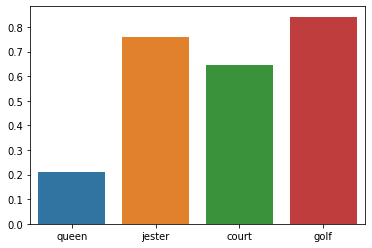

In [ ]:
# lets plot the distances as a barplot

sns.barplot(x=comp_list, y=comps[0])

In [ ]:
# so what did we see
# it was a small test, but conceptually we saw how these vectors can be compared
# we used distance to compare the numeric vectors and manually find the most similar
# contrived example, but sets up the concepts

In [ ]:
# there are some great toolkits that have been created
# to breakdown and explore all sorts of embeddings

# lots you can do here, but from some of the dev rel folks at rasa, which
# we will briefly see next class!
# https://github.com/RasaHQ/whatlies

In [ ]:
## let's go back to the tweet
doc

That movie by email@email.com was 🔥.  Please contact www.bu.edu

In [ ]:
# what do we get for a token that is OOV?

nlp('🔥').vector


dv = doc.vector

dv.shape

(300,)

In [ ]:
## what do you notice?
## this is a convention of spacy
## for OOV tokens, spacy doesn't fail, it simply returns an array of zeroes

In [ ]:
# lets review a doc vector


In [ ]:
# how do we think the doc vector is constructed?
vecs = []
for token in doc:
  vecs.append(token.vector)

# make it a numpy array
va = np.array(vecs)

vam = va.mean(axis=0)
vam.shape

# compare
np.all(vam == dv)

True

In [ ]:
va.shape

(11, 300)

In [ ]:
# remember spans?
# same still applies - token vectors are averaged over the docs and spans to represent the document

In [ ]:
#######################################  YOUR TURN
## 
## scrape the text from the three articles from the URLs below
## generate the doc vectors
## what is the most similar article to URL1 via cosine distance?
#
# URL1 = "https://www.boston.com/weather/weather/2021/11/26/boston-ma-snow-forecast-friday-nov-26-2021/"
# URL2 = "https://www.sportingnews.com/us/fantasy/news/nfl-week-12-weather-updates-lack-of-rain-wind-snow-in-forecast-eases-fantasy-football-start-em-sit-em-decisions/lueadzpkttxa1l2nzyr70hr18"
# URL3 = "https://www.marketwatch.com/story/the-u-s-stock-market-suffers-ugly-black-friday-selloff-here-are-the-biggest-losers-and-winners-11637952898"
## 


In [ ]:
#######################################  UP NEXT
## 
## Learn your own, domain-specific, word vectors
##
## Next Notebook
# 